#### Loading Data from SKAB Github

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from scipy.stats import gaussian_kde
import plotly.figure_factory as ff
# from utility_functions import *
# from models import *
from scipy.spatial import distance
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This is needed for 3D plotting
import plotly.graph_objs as go
from plotly.offline import iplot
import random
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import os
import math

c:\Users\VSIE43\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# random.seed(42)
# np.random.seed(42)
# torch.manual_seed(42)

In [3]:
s=123
random.seed(s)
np.random.seed(s)
torch.manual_seed(s)

In [7]:
data_pth = r'C:\Users\VSIE43\OneDrive - Scania CV\Thesis\SKAB-master\data/'
normal_file = 'anomaly-free/anomaly-free.csv'
test_1 = 'other'
test_2 = 'valve1'
test_3 = 'valve2'

df = pd.read_csv(data_pth+normal_file, sep=';')

In [ ]:
df.columns

In [8]:
def fillin_time_gaps(df):
    df.datetime = pd.to_datetime(df.datetime.values)
    time_diff = np.diff(df.datetime.values)

    # there will be need for data imputation. 
    # some samples are with differnce of 2 seconds, rather than 1 second
    new_time = pd.date_range(df.datetime.min(), df.datetime.max(),freq='1s')
    missing_time = pd.DataFrame({'datetime' : new_time})
    df_new = missing_time.merge(df, on='datetime', how='left')

    # maybe fill in with interpolation
    df_new = df_new.interpolate(method='ffill')
    return df_new

In [9]:
normal_data = []
df = pd.read_csv(data_pth+normal_file, sep=';')
normal_data.append(fillin_time_gaps(df).drop(columns=['datetime']))
for folder in [test_2, test_3]:
    files = os.listdir(data_pth+folder)
    print(files)
    for file in files:
        tmp = pd.read_csv(data_pth+folder+'/'+file, sep=';')
        # print(tmp.columns)
        # t = tmp[tmp.anomaly==1]
        t=tmp[tmp.anomaly==0]
        t = t.drop(columns=['datetime','anomaly','changepoint'])
        normal_data.append(t)

['0.csv', '1.csv', '10.csv', '11.csv', '12.csv', '13.csv', '14.csv', '15.csv', '2.csv', '3.csv', '4.csv', '5.csv', '6.csv', '7.csv', '8.csv', '9.csv']
['0.csv', '1.csv', '2.csv', '3.csv']


In [10]:
df = fillin_time_gaps(df)

In [11]:
def min_max_normalize(df, m_m_params=None):
    if m_m_params:
        (min_p, max_p) = m_m_params
    else:
        (min_p, max_p) = df.min(), df.max()

    new_df = (df-min_p) / (max_p-min_p)

    return new_df,  (min_p, max_p)


# data, m_m_params = min_max_normalize(df.drop(columns=['datetime']))
# ind = math.floor(0.8*len(data))
# train_data = data[:ind]
# val_data = data[ind:]
# # del data

In [12]:
def create_time_window(X, look_back=64):
    dataX = []
    for i in range(len(X)-look_back-1):
        a = X[i:(i+look_back), :]
        dataX.append(a)
    return np.array(dataX)

# train_x = create_time_window(train_data.values)
# val_x = create_time_window(val_data.values)

In [13]:
normal_data = []
df = pd.read_csv(data_pth+normal_file, sep=';')
normal_data.append(fillin_time_gaps(df).drop(columns=['datetime']))
for folder in [test_2, test_3]:
    files = os.listdir(data_pth+folder)
    print(files)
    for file in files:
        tmp = pd.read_csv(data_pth+folder+'/'+file, sep=';')
        # print(tmp.columns)
        # t = tmp[tmp.anomaly==1]
        t=tmp[tmp.anomaly==0]
        t = t.drop(columns=['datetime','anomaly','changepoint'])
        normal_data.append(t)

train_ext_x  = []
val_ext_x = []
tmp = []
[tmp.append(create_time_window(t.values)) for t in normal_data]
for t in tmp:
    ind = math.floor(0.8*len(t))
    val_ext_x.append(t[ind:])
    train_ext_x.append(t[:ind])

['0.csv', '1.csv', '10.csv', '11.csv', '12.csv', '13.csv', '14.csv', '15.csv', '2.csv', '3.csv', '4.csv', '5.csv', '6.csv', '7.csv', '8.csv', '9.csv']
['0.csv', '1.csv', '2.csv', '3.csv']


In [14]:
# creating data from more data

train_ext_x  = []
val_ext_x = []
tmp = []
[tmp.append(create_time_window(t.values)) for t in normal_data]
for t in tmp:
    ind = math.floor(0.8*len(t))
    val_ext_x.append(t[ind:])
    train_ext_x.append(t[:ind])

# [print(tmp.shape) for tmp in train_ext_x]
train_ext_x = np.concatenate(train_ext_x, axis=0)
new_m_m_parms =  train_ext_x.min(axis=(0,1)), train_ext_x.max(axis=(0,1))
train_ext_x,_ = min_max_normalize(train_ext_x, new_m_m_parms)

val_ext_x = np.concatenate(val_ext_x, axis=0)
val_ext_x,_ = min_max_normalize(val_ext_x, new_m_m_parms)


# l_ind = len(train_ext_x)-math.floor(len(train_ext_x)*.8)
# rand_index = np.random.randint(0,len(train_ext_x),l_ind)

# val_ext_x = train_ext_x[rand_index]
# train_ext_x = np.delete(train_ext_x,rand_index)
# val_ext_x = train_ext_x[ind:]
# train_ext_x = train_ext_x[:ind]

In [15]:
val_ext_x.shape

(4658, 64, 8)

In [16]:
train_ext_x.shape

(18584, 64, 8)

In [17]:
def array_to_dataloader(data, batch_size, shuffle):

    data_tensor = torch.tensor(data, dtype=torch.float32)
    print(data_tensor.transpose(1,2).shape)
    dataset_ae = TensorDataset(data_tensor.transpose(1,2), data_tensor.transpose(1,2))
    dataloader_ae = DataLoader(dataset_ae, batch_size=batch_size, shuffle=shuffle)

    return dataloader_ae

In [18]:
train_dataloader = array_to_dataloader(train_ext_x, batch_size=32, shuffle=False)
val_dataloader = array_to_dataloader(val_ext_x, batch_size=32, shuffle=False)

torch.Size([18584, 8, 64])
torch.Size([4658, 8, 64])


##### Test Data

In [19]:
def plot_data(data):
    num_columns = len(data.columns)
    nrows = num_columns  # One row for each column

    # Decrease the height allocated to each subplot by reducing the second element of the figsize tuple.
    # Adjust the 5 in figsize=(10, 5) based on your preference and the actual number of subplots.
    height_per_subplot = 1  # Adjust this value to change the height per subplot
    fig = plt.figure(figsize=(10, height_per_subplot * nrows))
    
    # Create subplots with adjusted spacing using 'subplots_adjust' if necessary.
    # The 'hspace' parameter controls the height of the padding between subplots.
    gs = fig.add_gridspec(nrows, 1, hspace=0.35)  # Adjust hspace as needed
    
    for i, column in enumerate(data.columns):
        ax = fig.add_subplot(gs[i, 0])

        # Plot the line on the ith subplot
        ax.plot(data[column], label=f'Signal_{i+1}')
        
        # Set y-axis to show only the min and max values
        col_min = data[column].min()
        col_max = data[column].max()
        ax.set_ylim(col_min, col_max)
        ax.set_yticks([col_min, col_max])  # Show only ticks for min and max
        
        # Format the y-tick labels
        ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
        
        # Set title aligned to the left
        ax.set_title(f'{data.columns[i]}', loc='left', fontsize=15, verticalalignment='center')
        
        # Show legend with column name
        # ax.legend(loc='upper right')

        # Make x-axis ticks visible only for the last subplot
        if i < num_columns - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Time')
            ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Adjust the layout to prevent overlap and save the figure
    plt.tight_layout()
    plt.savefig('compact_subplots.png')
    plt.show()

In [20]:
test_df_1 = pd.read_csv(data_pth+test_1+'/1.csv',sep=';')
test_df_1_norm, _  = min_max_normalize(test_df_1.drop(columns=['datetime','anomaly','changepoint']),new_m_m_parms)
test_x = create_time_window(test_df_1_norm.values)

C:\Users\VSIE43\AppData\Local\Temp\ipykernel_13364\4204291720.py:43: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



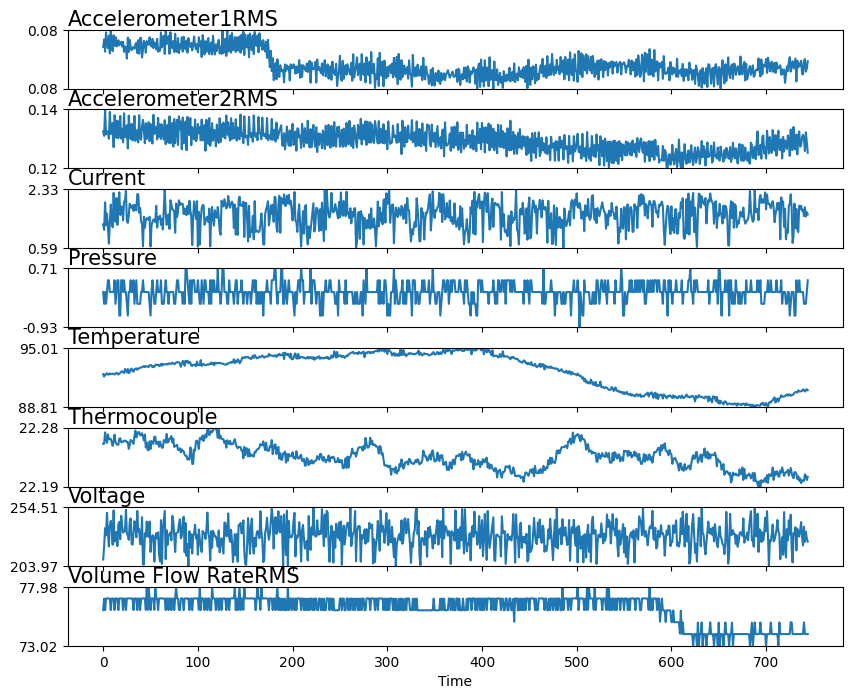

In [21]:
plot_data(test_df_1.drop(columns=['datetime','anomaly','changepoint']))

In [ ]:
plot_data(test_df_1_norm)

In [ ]:
test_x.shape

In [22]:
test_dataloader = array_to_dataloader(test_x, batch_size=32, shuffle=False)

torch.Size([680, 8, 64])


#### Conv1D AE - Anomaly Detection

In [23]:
class Conv1DAutoencoder(nn.Module):
    def __init__(self, num_features):
        super(Conv1DAutoencoder, self).__init__()

        self.total_features = num_features
        # Define the encoder layers
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=self.total_features, out_channels=32, kernel_size=5, padding =2),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU()
        )

        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,8)

        self.fc4 = nn.Linear(8, 16)
        self.fc5 = nn.Linear(16, 32)
        self.fc6 = nn.Linear(32, 64)

        # Define the decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=self.total_features, kernel_size=5, padding=2),
            nn.ReLU()
        )

    
    def encode(self, x):

        x_enc = self.encoder(x)
        x_enc = self.fc1(x_enc)
        
        embedding = self.fc2(x_enc)
        embedding = self.fc3(embedding)
        embedding = self.fc4(embedding)
        embedding = self.fc5(embedding)
        embedding = self.fc6(embedding)

        return embedding

    def decode(self, embedding):
        x_dec = self.decoder(embedding)
        

        # Reshape outputs if necessary to match the original input shape
        return x_dec


    def forward(self, x):
        
        embedding = self.encode(x)

        x_out = self.decode(embedding)
        # print(x_out.shape)
        return x_out

#### Model Instantiation

In [24]:
tot_num_features = train_ext_x.shape[2]
tot_num_features

8

In [25]:
ae_model = Conv1DAutoencoder(num_features=tot_num_features)
optimizer = optim.Adam(ae_model.parameters(), lr=0.001, amsgrad=True,)

##### Custom Loss Function

In [26]:
def custom_loss(pred, target):
    # Initialize the L1 Loss function
    l1_loss = nn.SmoothL1Loss(beta=0.5)
    
    # Calculate loss
    loss = l1_loss(pred, target)

    return loss

In [ ]:
num_epochs = 100
train_losses, val_losses = [], []

# Initialize the variable to track the lowest validation loss
best_val_loss = float('inf')
best_model_path_ae = 'Models/best_model_autoencoder_skab_seed'+str(s)+'.pth'

for epoch in range(num_epochs):
    ae_model.train()  # Set the model to training mode
    train_loss = 0.0
    
    for data, target in train_dataloader:
        # Assuming your model's forward method returns the reconstructed output
        output = ae_model(data)
        
        # Assuming custom_loss is defined to compute the loss between the output and the target
        loss = custom_loss(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    ae_model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for data, target in val_dataloader:
            output = ae_model(data)
            loss = custom_loss(output, target)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Check if the current epoch's validation loss is lower than the best seen so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Save the current best model
        torch.save(ae_model.state_dict(), best_model_path_ae)
        print(f"Epoch {epoch+1}: New best model saved with loss {avg_val_loss:.4f}")

# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
best_model_path_ae = 'C:/Users/VSIE43/OneDrive - Scania CV/Thesis/Models/best_model_autoencoder_skab_seed123.pth'  # Define path to save the best model
best_model_ae = ae_model  # Assuming 'model' is an instance of your model class
best_model_ae.load_state_dict(torch.load(best_model_path_ae))
print("Loaded the best model.")
print(best_model_ae)

Loaded the best model.
Conv1DAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(8, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): ReLU()
  )
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=64, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): ConvTranspose1d(32, 8, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): ReLU()
  )
)


In [28]:
def reconstruct_original_sequences(dataloader):
    original_sequences = []

    # Iterate over both dataloaders simultaneously
    for data, _ in dataloader:

        original_sequences.append(data.cpu().numpy())

    original_sequences = np.concatenate(original_sequences, axis=0)
    
    return original_sequences

In [29]:
original_train_sequences = reconstruct_original_sequences(train_dataloader)
original_val_sequences = reconstruct_original_sequences(val_dataloader)
original_test_sequences = reconstruct_original_sequences(test_dataloader)
# original_test_sequences_rearWheel = reconstruct_original_sequences(anom_dataloader_rearWheel)
print("Original Train Shape:", original_train_sequences.shape)
print("Original Validation  Shape:", original_val_sequences.shape)
print("Original Test Shape:", original_test_sequences.shape)

Original Train Shape: (18584, 8, 64)
Original Validation  Shape: (4658, 8, 64)
Original Test Shape: (680, 8, 64)


In [30]:
def plot_model_predictions(model, dataloader, original_sequences, window_index, feature_index):
    model.eval()  # Ensure the model is in evaluation mode
    all_predicted_signals = []

    with torch.no_grad():  # No gradient needed for evaluation
        # Loop through all batches in the DataLoader
        for data, _ in dataloader:
            # Predict using the model for each batch
            pred = model(data)
            
            all_predicted_signals.append(pred)
        
        # Concatenate all predictions across batches
        all_predicted_signals = torch.cat(all_predicted_signals, dim=0)
    all_predicted_signals = np.array(all_predicted_signals)
    # Ensure the concatenated predictions match the original sequences' shape
    # print(f"Predicted Signals Shape: {all_predicted_signals.shape}")
    # print(f"Original Sequences Shape: {original_sequences.shape}")

    # Plotting (adjust as necessary for your specific needs)
    # Example: Plotting the first feature of the first sequence
    # plt.figure(figsize=(15, 5))
    # plt.plot(original_sequences[window_index, feature_index, :], label='Original Signal', marker='o')  # Adjust indexing as per your data shape
    # plt.plot(all_predicted_signals[window_index, feature_index, :], label='Reconstructed Signal', marker='x')  # Adjust indexing as per your data shape
    # plt.title('Original vs. Reconstructed Signals')
    # plt.xlabel('Window Length')
    # plt.ylabel('Feature Value')
    # plt.legend()
    # plt.savefig('reconstruction_plots.png', bbox_inches='tight', dpi=1000)
    # plt.show()

    return all_predicted_signals

In [31]:
train_recon_ae_signals = plot_model_predictions(best_model_ae, 
                                                train_dataloader, 
                                                original_train_sequences, 
                                                window_index=1500, feature_index=0)

In [32]:
valid_recon_ae_signals = plot_model_predictions(best_model_ae, 
                                                val_dataloader, 
                                                original_val_sequences, 
                                                window_index=1000, feature_index=1)

In [33]:
test_recon_ae_signals = plot_model_predictions(best_model_ae, 
                                               test_dataloader, 
                                               original_test_sequences, 
                                               window_index=600, 
                                               feature_index=5)

#### Computing Reconstruction Error - Window and Sample Based

##### Window Loss

In [34]:
train_loss_mae_mse_ae = (train_recon_ae_signals[:,:20,:] - original_train_sequences[:,:20,:])**2 + np.abs(train_recon_ae_signals[:,:20,:] - original_train_sequences[:,:20,:])
valid_loss_mae_mse_ae = (valid_recon_ae_signals[:,:20,:] - original_val_sequences[:,:20,:])**2 + np.abs(valid_recon_ae_signals[:,:20,:] - original_val_sequences[:,:20,:])
test_loss_mae_mse_ae = (test_recon_ae_signals[:,:20,:] - original_test_sequences[:,:20,:])**2 + np.abs(test_recon_ae_signals[:,:20,:] - original_test_sequences[:,:20,:])
# test_loss_mae_mse_ae_rearWheel = (test_recon_ae_signals_rearWheel[:,:20,:] - original_test_sequences_rearWheel[:,:20,:])**2 + np.abs(test_recon_ae_signals_rearWheel[:,:20,:] - original_test_sequences_rearWheel[:,:20,:])

print('Train_cont Window Losses:', train_loss_mae_mse_ae.shape)
print('Valid_cont Window Losses:', valid_loss_mae_mse_ae.shape)
print('Test_cont Window Losses:', test_loss_mae_mse_ae.shape)
# print('Test_cont Window Losses:', test_loss_mae_mse_ae_rearWheel.shape)

Train_cont Window Losses: (18584, 8, 64)
Valid_cont Window Losses: (4658, 8, 64)
Test_cont Window Losses: (680, 8, 64)


##### Sample Loss

In [35]:
train_sample_loss_ae = np.mean(train_loss_mae_mse_ae, axis=2).mean(axis = 1)
valid_sample_loss_ae = np.mean(valid_loss_mae_mse_ae, axis=2).mean(axis = 1)
test_sample_loss_ae = np.mean(test_loss_mae_mse_ae, axis=2).mean(axis = 1)

print('Train_cont Sample Losses:', train_sample_loss_ae.shape)
print('Valid_cont Sample Losses:', valid_sample_loss_ae.shape)
print('Test_cont Sample Losses:', test_sample_loss_ae.shape)

Train_cont Sample Losses: (18584,)
Valid_cont Sample Losses: (4658,)
Test_cont Sample Losses: (680,)


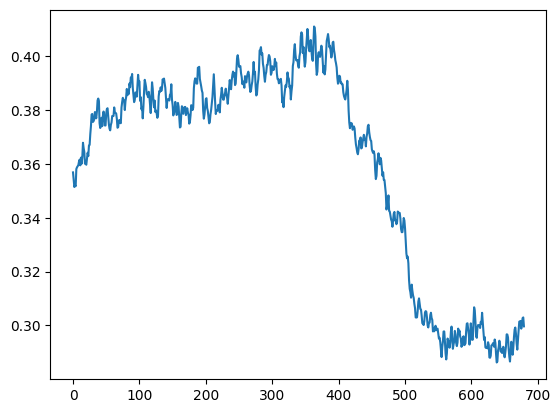

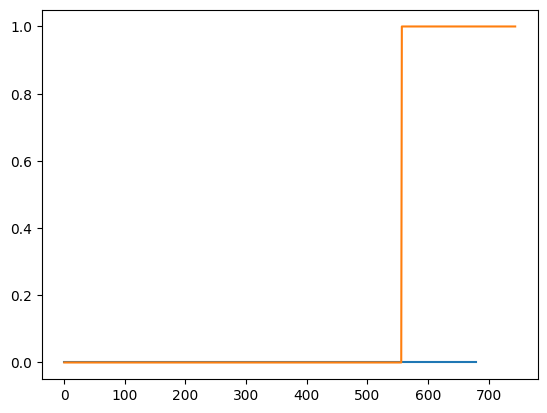

In [36]:
plt.plot(test_sample_loss_ae)
# plt.plot(test_df_1.anomaly)
plt.figure()
plt.plot(test_sample_loss_ae>0.6)
plt.plot(test_df_1.anomaly.values)

##### Feature Loss

In [ ]:
train_feature_loss_ae = np.mean(train_loss_mae_mse_ae, axis=2)
valid_feature_loss_ae = np.mean(valid_loss_mae_mse_ae, axis=2)
test_feature_loss_ae = np.mean(test_loss_mae_mse_ae, axis=2)

print('Train_cont Feature Losses:', train_feature_loss_ae.shape)
print('Valid_cont Feature Losses:', valid_feature_loss_ae.shape)
print('Test_cont Feature Losses:', test_feature_loss_ae.shape)

#### Anomaly Threshold and Rate

##### Anomaly Threshold Based on Validation Sample Losses

In [37]:
Q1 = np.percentile(valid_sample_loss_ae, 25)
Q3 = np.percentile(valid_sample_loss_ae, 75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Determine the threshold as Q3 + multiplier * IQR
ae_threshold = Q3 + 4 * IQR
ae_threshold

0.11804353073239326

In [ ]:
# ae_threshold = np.percentile(valid_sample_loss_ae, 100, axis=0)
# ae_threshold
# sns.histplot(train_losses, kde=True, color='red', alpha=0.2, edgecolor='black')
fig = sns.histplot(valid_sample_loss_ae, kde=True, color='blue', alpha=0.3, edgecolor='black')
fig.axvline(x = ae_threshold, linestyle = 'dashed', color = 'red')

In [ ]:
ae_threshold

In [ ]:
# ae_threshold = valid_sample_loss_ae.mean() + 9*valid_sample_loss_ae.std()
# ae_threshold

##### Anomaly Rate - Training, Validation and Test

In [ ]:
anomalyrate1 = (train_sample_loss_ae > ae_threshold).sum()/len(train_sample_loss_ae)
anomalyrate2 = (valid_sample_loss_ae > ae_threshold).sum()/len(valid_sample_loss_ae)
anomalyrate3 = (test_sample_loss_ae > ae_threshold).sum()/len(test_sample_loss_ae)

print('threshold',ae_threshold)
print('anomalyrate - train', anomalyrate1)
print('anomalyrate - valid', anomalyrate2)
print('anomalyrate - test', anomalyrate3)

##### Automatic Feature Selector

In [ ]:
sensor_names = ['Sensor_' + str(i) for i in range(test_loss_mae_mse_ae.shape[1])]
plt.figure(figsize=(6, 6))
heatmap = sns.heatmap(np.swapaxes(test_loss_mae_mse_ae,1,2)[400], xticklabels=sensor_names, cmap="viridis")
heatmap.set_title('Reconstruction Losses(Window Based) Heatmap')
heatmap.set_xlabel('Number of Features/Sensors')
heatmap.set_ylabel('Window length')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('recon_errors.png', bbox_inches='tight', dpi=1000)
plt.show()

#### Anomaly Detection Evaluation Metrics:

In [ ]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

In [ ]:
 # metrics

def  f1_score(true, pred):
    return metrics.f1_score(true, pred)

def recall_score(true, pred):
    return metrics.recall_score(true, pred)

def auc_score(true, pred):
    return metrics.roc_auc_score(true, pred)

def fpr_score(true, pred):
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    # print(c.shape)
    # FP = c.sum(axis=0) - np.diag(c)  
    # FN = c.sum(axis=1) - np.diag(c)
    # TP = np.diag(c)
    # TN = c.sum() - (FP + FN + TP)

    return fp/(fp+tn)

In [38]:
preds = []
labels = []
file_number = []
# m = model_ext
test_sample_loss_all = []

files = os.listdir(data_pth+test_1)

print(files)
for file in files:
    tmp = pd.read_csv(data_pth+test_1+'/'+file, sep=';')
    t = tmp.anomaly.values
    test_df_1_norm, _  = min_max_normalize(tmp.drop(columns=['datetime','anomaly','changepoint']).values,new_m_m_parms)
    test_x = create_time_window(test_df_1_norm)
    test_dataloader = array_to_dataloader(test_x, batch_size=32, shuffle=False)
    original_test_sequences = reconstruct_original_sequences(test_dataloader)
    test_recon_ae_signals = plot_model_predictions(best_model_ae, 
                                               test_dataloader, 
                                               original_test_sequences, 
                                               window_index=600, 
                                               feature_index=5)
    test_loss_mae_mse_ae = (test_recon_ae_signals - original_test_sequences)**2 + np.abs(test_recon_ae_signals - original_test_sequences)
    test_sample_loss_ae = np.mean(test_loss_mae_mse_ae, axis=2).mean(axis = 1)
    test_sample_loss_all.append(test_sample_loss_ae)
    labels.append(t[-len(test_recon_ae_signals):])
    i = int(file.split('.')[0])
    file_number.append([i]*len(test_recon_ae_signals))
    preds.append(test_sample_loss_ae>ae_threshold)
    # i +=1
    
preds = np.concatenate(preds, axis=0)
labels = np.concatenate(labels, axis=0)
file_number = np.concatenate(file_number, axis=0)

['1.csv', '10.csv', '11.csv', '12.csv', '13.csv', '14.csv', '2.csv', '3.csv', '4.csv', '5.csv', '6.csv', '7.csv', '8.csv', '9.csv']
torch.Size([680, 8, 64])
torch.Size([1262, 8, 64])
torch.Size([1125, 8, 64])
torch.Size([983, 8, 64])
torch.Size([858, 8, 64])
torch.Size([840, 8, 64])
torch.Size([715, 8, 64])
torch.Size([1072, 8, 64])
torch.Size([1126, 8, 64])
torch.Size([1090, 8, 64])
torch.Size([1082, 8, 64])
torch.Size([1025, 8, 64])
torch.Size([1082, 8, 64])
torch.Size([1079, 8, 64])


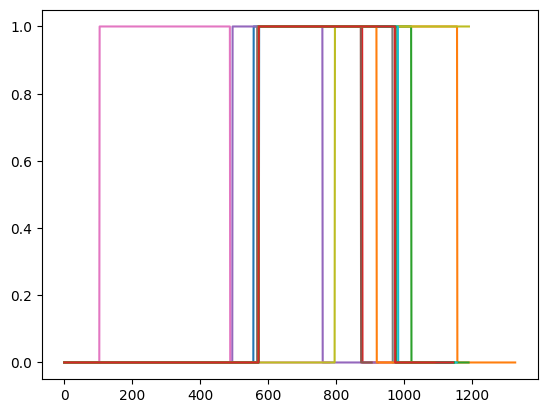

In [40]:
tmp_anom_list = []
for file in files:
    tmp_df = pd.read_csv(data_pth+test_1+'/'+file, sep=';')
    tmp_anom_list.append(tmp_df.anomaly)
    plt.plot(tmp_df.anomaly)

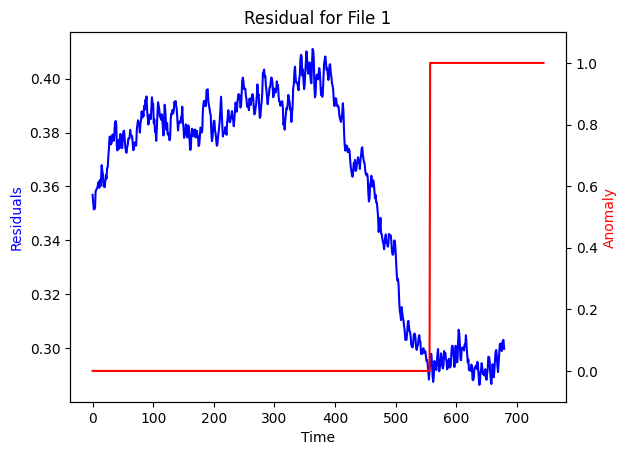

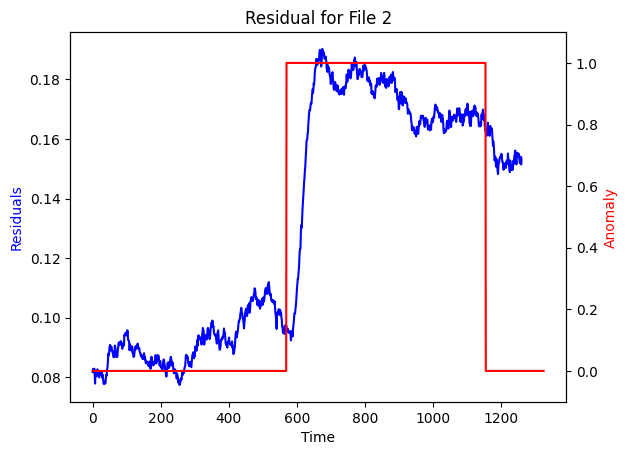

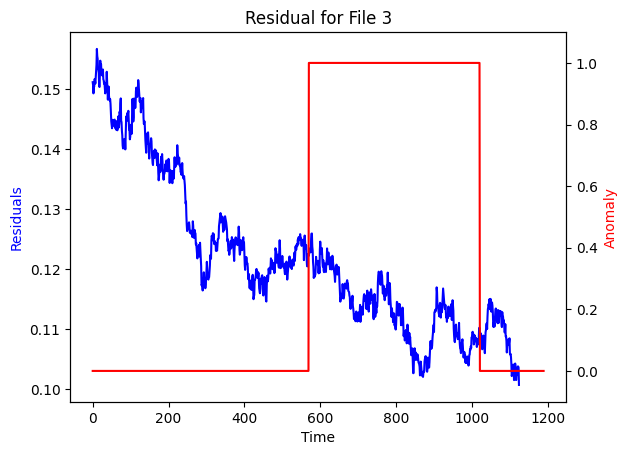

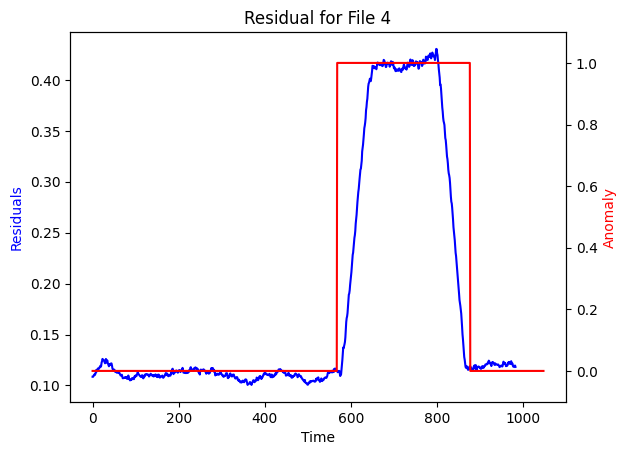

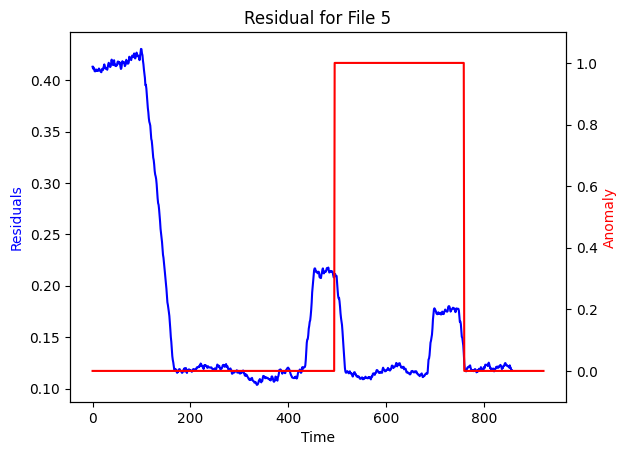

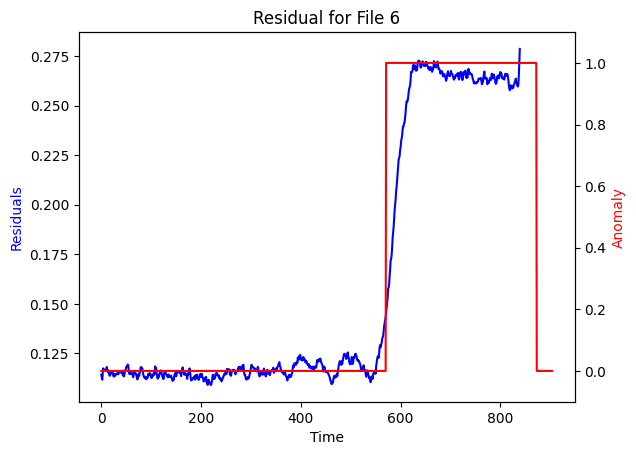

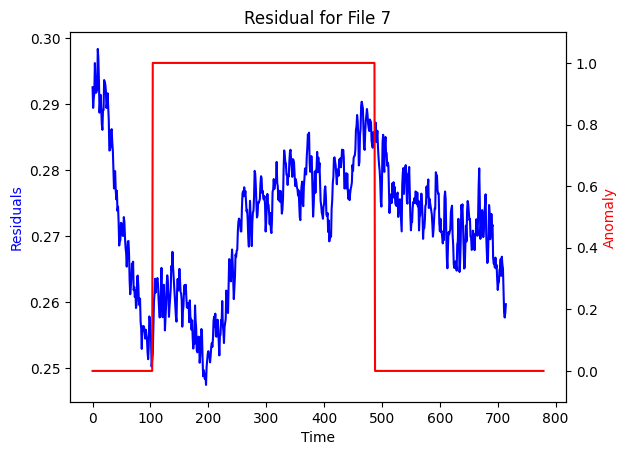

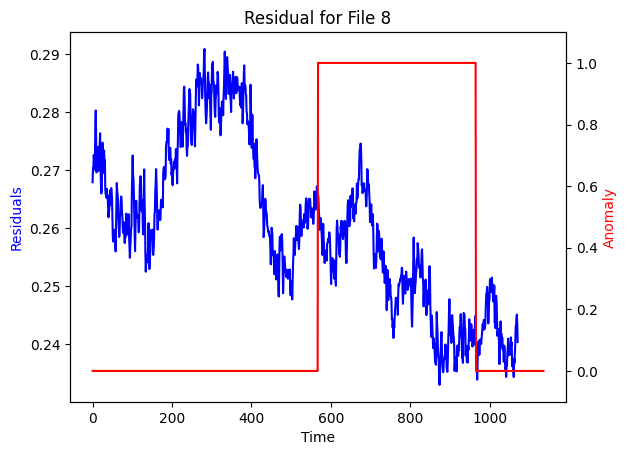

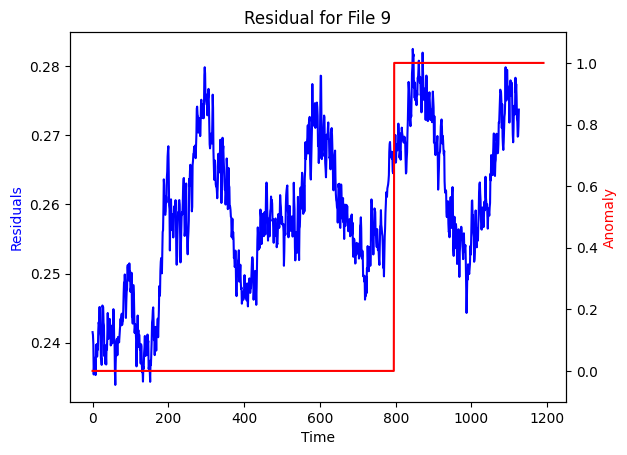

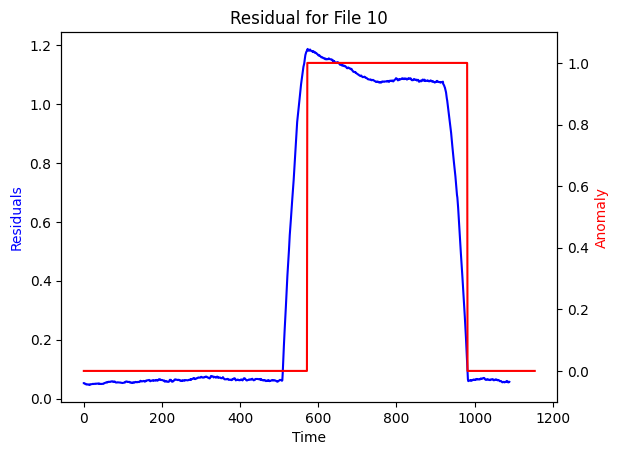

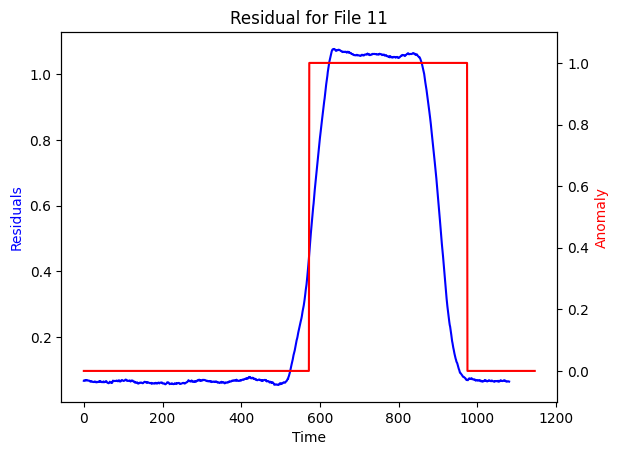

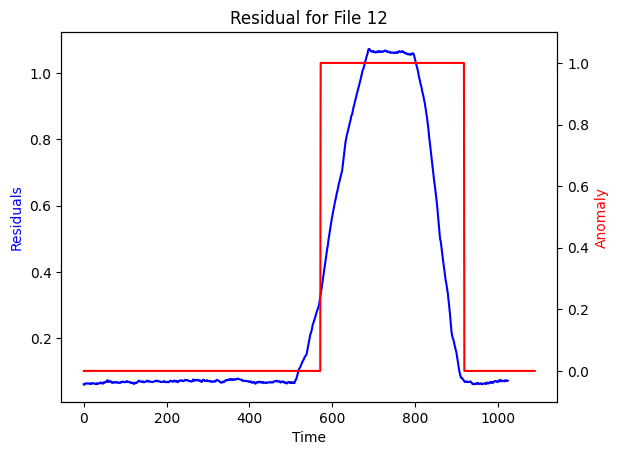

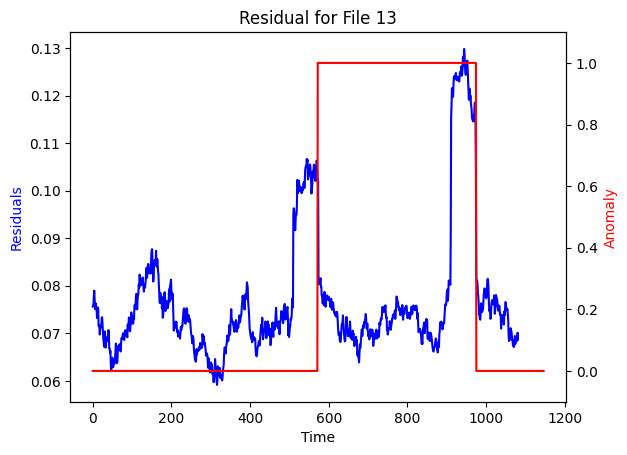

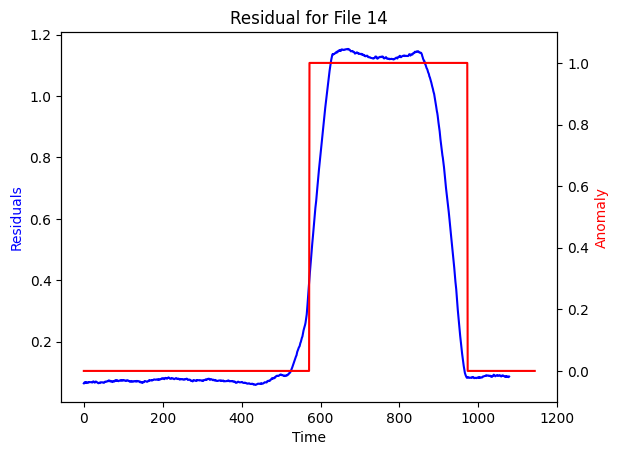

In [41]:
for i in range(len(test_sample_loss_all)):
    fig, ax1 = plt.subplots()  # Create a new figure and axis for residuals

    ax1.plot(test_sample_loss_all[i], 'b-')
    ax1.set_title(f'Residual for File {i+1}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Residuals', color='b')

    ax2 = ax1.twinx()  # Create a second y-axis
    ax2.plot(tmp_anom_list[i], 'r-')
    ax2.set_ylabel('Anomaly', color='r')
    ax2.set_ylim(-0.1, 1.1)  # Set limits for the anomaly axis

    plt.show()

In [ ]:
tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()

In [ ]:
fp / (tp+fp)

In [ ]:
ind = np.in1d(file_number, list(range(5,15)))
# print(np.unique(ind))
recall_score(labels[ind],preds[ind])

In [ ]:
f1_score(labels,preds)

In [ ]:
for i, fun in enumerate([f1_score, fpr_score, recall_score, auc_score]):
    print()
    print(['f1_score', 'fpr_score', 'recall_score', 'auc_score'][i])
    for f in range(1,15):
        print(fun(labels[file_number==f],preds[file_number==f]))

In [ ]:
f1_values = [
    0.4331797235023042, 0.6988171064604185, 0.5414965986394558, 0.5193951347797502,
    0.9227272727272727, 0.9318734793187349, 0.9063360881542699, 0.0,
    0.9093078758949881, 0.7649467649467651, 0.005813953488372093, 0.7843803056027165,
    0.2797202797202797, 0.8590831918505943
]

fpr_values = [
    1.0, 1.0, 1.0, 1.0, 0.09411764705882353, 0.054411764705882354,
    0.07374631268436578, 0.004418262150220913, 0.08259587020648967,
    0.2485207100591716, 0.3486646884272997, 0.07270029673590504,
    0.3827993254637437, 0.06319702602230483
]

recall_values = [
    1.0, 1.0, 1.0, 1.0, 0.9902439024390244, 0.9527363184079602,
    0.9481268011527377, 0.0, 0.9501246882793017, 0.7969283276450512,
    0.004434589800443459, 0.7475728155339806, 0.3018867924528302,
    0.8377483443708609
]

# Function to calculate the average of a list of numbers
def calculate_average(scores):
    return sum(scores) / len(scores)

# Calculating averages for each metric by the specified groupings
f1_averages = {
    "First 4": calculate_average(f1_values[:4]),
    "Next 5": calculate_average(f1_values[4:9]),
    "Next 2": calculate_average(f1_values[9:11]),
    "Next 2 (Cavitation)": calculate_average(f1_values[11:13])}

recall_averages = {
    "First 4": calculate_average(recall_values[:4]),
    "Next 5": calculate_average(recall_values[4:9]),
    "Next 2": calculate_average(recall_values[9:11]),
    "Next 2 (Cavitation)": calculate_average(recall_values[11:13])}

fpr_averages = {
    "First 4": calculate_average(fpr_values[:4]),
    "Next 5": calculate_average(fpr_values[4:9]),
    "Next 2": calculate_average(fpr_values[9:11]),
    "Next 2 (Cavitation)": calculate_average(fpr_values[11:13])}

print('F1:',f1_averages)
print('Recall:',recall_averages)
print('FPR:',fpr_averages)

In [ ]:
np.mean(np.array([0.4331797235023042,
        0.6988171064604185,
        0.5414965986394558,
        0.5193951347797502,
        0.9229024943310657,
        0.9258809234507897,
        0.9050894085281981,
        0.0,
        0.9066985645933014,
        0.7790322580645161,
        0.2912801484230056,
        0.6535764375876577,
        0.34068627450980393,
        0.7657784011220197]))

#### Counterfactuals - Gradient Approach

In [ ]:
def create_counterfactuals_adam_pytorch(dataloader, model, threshold=-np.inf, learning_rate=0.01, num_iterations=1000, exclude_signals=[]):
    model.eval()
    
    all_counterfactuals = []
    all_losses = []  # List to store losses for each batch

    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.clone().detach().requires_grad_(True)
        optimizer_data = torch.optim.Adam([data], lr=learning_rate)

        batch_losses = []  # List to store losses for the current batch

        for i in range(num_iterations):
            optimizer_data.zero_grad()
            output = model(data)
            loss = torch.mean(F.mse_loss(output, data, reduction='mean') + F.l1_loss(output, data, reduction='mean'))

            if loss.item() < threshold:
                break

            loss.backward()
            batch_losses.append(loss.item())  # Store the loss value for this iteration

            if exclude_signals:
                with torch.no_grad():
                    for exclude_signal in exclude_signals:
                        data.grad[:, exclude_signal, :] = 0
            optimizer_data.step()

        all_counterfactuals.append(data.detach().numpy())
        all_losses.append(batch_losses)  # Store the losses for this batch
        plt.plot(batch_losses)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title(f'Loss over Iterations for Batch {batch_idx}')
        plt.show()
        batch_losses = []
    # Combine all batches of counterfactuals into a single numpy array
    all_counterfactuals = np.concatenate(all_counterfactuals, axis=0)
    
    # Return both the counterfactuals and the aggregated losses
    return all_counterfactuals, all_losses

In [ ]:
all_feature_indices = list(range(tot_num_features))
validity_datasets = []
sparsity_datasets = []
proximity_datasets = []
for i in range(5,6):
    print()
    print('File number: ', i)
    test_df_1 = pd.read_csv(data_pth+test_1+'/'+str(i)+'.csv',sep=';')
    test_df_1_norm, _  = min_max_normalize(test_df_1.drop(columns=['datetime','anomaly','changepoint']).values,new_m_m_parms)
    test_x = create_time_window(test_df_1_norm)
    test_dataloader = array_to_dataloader(test_x, batch_size=32, shuffle=False)
    original_test_sequences = reconstruct_original_sequences(test_dataloader)
    test_recon_ae_signals = plot_model_predictions(best_model_ae, 
                                               test_dataloader, 
                                               original_test_sequences, 
                                               window_index=600, 
                                               feature_index=5)
    test_loss_mae_mse_ae = (test_recon_ae_signals - original_test_sequences)**2 + np.abs(test_recon_ae_signals - original_test_sequences)
    test_sample_loss_ae = np.mean(test_loss_mae_mse_ae, axis=2).mean(axis = 1)
    test_feature_loss_ae = np.mean(test_loss_mae_mse_ae, axis=2)
    # sns.heatmap(test_feature_loss_ae)
    # sns.pairplot(test_df_1.drop(columns=['datetime','changepoint']), hue='anomaly')
    # scaler = MinMaxScaler()
    lof = LocalOutlierFactor(n_neighbors=2, contamination=0.5, algorithm='ball_tree',metric='euclidean')
    feature_losses_transposed = test_feature_loss_ae.T
    # feature_losses_transposed_scaled = scaler.fit_transform(feature_losses_transposed)
    anomalies = lof.fit_predict(feature_losses_transposed)

    # Anomalies are marked with -1, so we can find them like this:
    anomalous_feature_indices = np.where(anomalies == -1)[0]
    
    print("Anomalous Feature Indices:", anomalous_feature_indices)

    exclude_signals = [index for index in all_feature_indices if index not in anomalous_feature_indices]

    print("Exclude Signals Mask:", exclude_signals)
    # plt.plot(test_sample_loss_ae)
    # plt.figure()
    # plt.plot(test_sample_loss_ae>ae_threshold)
    # plt.plot(test_df_1.anomaly.values[-len(test_sample_loss_ae):])
    # plt.show()
    cf_anom, losses = create_counterfactuals_adam_pytorch(dataloader=test_dataloader, 
                                            model=best_model_ae, 
                                            num_iterations=350, 
                                            learning_rate=0.01,exclude_signals=exclude_signals)

    cf_data_tensor = torch.tensor(cf_anom, dtype=torch.float32)
    cf_dataset = TensorDataset(cf_data_tensor, cf_data_tensor)
    cf_dataloader = DataLoader(cf_dataset, batch_size=32, shuffle=False)
    original_cf_sequences = reconstruct_original_sequences(cf_dataloader)
    recon_cf_signals = plot_model_predictions(best_model_ae, 
                                            cf_dataloader,
                                            original_cf_sequences,
                                            195,
                                            2)

    cf_loss_mae_mse_ae = (recon_cf_signals - original_cf_sequences)**2 + np.abs(recon_cf_signals - original_cf_sequences)
    cf_sample_loss_ae = np.mean(cf_loss_mae_mse_ae, axis=2).mean(axis = 1)

    print('CF_cont Sample Losses:', cf_sample_loss_ae.shape)
    valid_counterfactuals = np.mean(cf_sample_loss_ae < ae_threshold)
    print(f'File Number {i} and its corresponding validity: {valid_counterfactuals}')
    validity_datasets.append(valid_counterfactuals)
    distances_per_timestep = np.sqrt(np.sum((original_test_sequences - cf_anom) ** 2, axis=2))

    average_distances_per_sequence = np.mean(distances_per_timestep, axis=1)

    overall_average_distance_per_window = np.mean(average_distances_per_sequence)
    print(f'File Number {i} and its corresponding distance metric: {overall_average_distance_per_window}')
    proximity_datasets.append(overall_average_distance_per_window)

    change_threshold = 0.001

    differences_exceed_threshold = np.abs(original_test_sequences - cf_anom) > change_threshold

    sparsity_per_sequence = np.sum(differences_exceed_threshold, axis=(1, 2)) / (original_test_sequences.shape[1] * original_test_sequences.shape[2])

    overall_average_sparsity = np.mean(sparsity_per_sequence)
    print(f'File Number {i} and its corresponding sparsity metric: {overall_average_sparsity}')
    sparsity_datasets.append(overall_average_sparsity)

In [ ]:
plt.plot(test_x[100,:,4])
plt.plot(cf_anom[100,4,:])

In [ ]:
def get_anomalous_classified_window(model, threshold, norm_parameter=new_m_m_parms, files=range(1,15), is_fp_tp=False):
    data = []
    file_number = []
    fps = []
    tps = []
    for i in files:
        print(i)
        test_df_1 = pd.read_csv(data_pth+test_1+'/'+str(i)+'.csv',sep=';')
        label= test_df_1['anomaly'][65:] 
        test_df_1_norm, _  = min_max_normalize(test_df_1.drop(columns=['datetime','anomaly','changepoint']).values,norm_parameter)
        test_x = create_time_window(test_df_1_norm)
        test_dataloader = array_to_dataloader(test_x, batch_size=32, shuffle=False)
        original_test_sequences = reconstruct_original_sequences(test_dataloader)
        test_recon_ae_signals = plot_model_predictions(model, 
                                                test_dataloader, 
                                                original_test_sequences, 
                                                window_index=600, 
                                                feature_index=5)
        test_loss_mae_mse_ae = (test_recon_ae_signals - original_test_sequences)**2 + np.abs(test_recon_ae_signals - original_test_sequences)
        test_sample_loss_ae = np.mean(test_loss_mae_mse_ae, axis=2).mean(axis = 1)
        t = test_sample_loss_ae>threshold
        data.append(test_x[t])
        file_number.append([i]*len(data[-1]))
        fps.append(np.logical_and(label==0,t==1)[t==1])
        tps.append(np.logical_and(label==1,t==1)[t==1])

    if is_fp_tp:
        return np.concatenate(data), np.concatenate(file_number), np.concatenate(fps), np.concatenate(tps)
        
    return np.concatenate(data), np.concatenate(file_number)

In [ ]:
files = range(5,15)#[5,6,7,9,13,14]
data,file_num, ano_fps, ano_tps = get_anomalous_classified_window(best_model_ae,ae_threshold, files=files,is_fp_tp=True)

In [ ]:


# method 2 using feature wise threshold

# testing option 1
test_data = []
labels_1 = []
file_number = []
# m = model_ext


files = os.listdir(data_pth+test_1)

print(files)
for file in files:
    tmp = pd.read_csv(data_pth+test_1+'/'+file, sep=';')
    t = tmp.anomaly.values
    test_df_1_norm, _  = min_max_normalize(tmp.drop(columns=['datetime','anomaly','changepoint']).values,new_m_m_parms)
    test_x = create_time_window(test_df_1_norm)
    # pred_x = model_ext.predict(test_x)
    labels_1.append(t[-len(test_x):])
    i = int(file.split('.')[0])
    file_number.append([i]*len(test_x))
    test_data.append(test_x)
    # preds.append(anomaly_score_no_mean(np.squeeze(pred_x),np.squeeze(test_x)).mean(axis=1)>threshold)
    # preds.append(np.any(anomaly_score_no_mean(np.squeeze(pred_x),np.squeeze(test_x)).mean(axis=1)>threshold_feature, axis=1))
    # break
    
# preds = np.concatenate(preds, axis=0)
test_data = np.concatenate(test_data)
labels_1 = np.concatenate(labels_1, axis=0)
file_number = np.concatenate(file_number, axis=0)


dict_to_save = {'ano_data':data, 'cf_data':cf_anom, 'file_num':file_number }
dict_to_save['test_data']=test_data
dict_to_save['test_labels']=labels_1
dict_to_save['test_file_num']=file_number

dict_to_save['train_data']=train_ext_x

import pickle as pk
pk.dump(dict_to_save, open('skab_ae_grad.pk','wb'))

In [ ]:
import os
import pickle
import umap
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
# Check current working directory
print("Current working directory:", os.getcwd())

# Path to the pickle file
file_path_skab = 'skab_ae_grad.pk' 

# Attempt to open the file with error handling
try:
    with open(file_path_skab, 'rb') as file:
        var_skab = pickle.load(file)
    print("File loaded successfully")
except FileNotFoundError:
    print(f"File not found: {file_path_skab}")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
anomaly_data_skab = var_skab['ano_data']
ano_file_skab = var_skab['file_num']
cf_data_skab = var_skab['cf_data']

train_data_skab = var_skab['train_data']
test_data_skab = var_skab['test_data']
combined_file_num_skab = var_skab['test_file_num']

index_counts_skab = Counter(combined_file_num_skab)

In [ ]:
exclude_indices = index_counts_skab[1] + index_counts_skab[2] + index_counts_skab[3] + index_counts_skab[4]

In [ ]:
exclude_ind_test_data = test_data_skab[exclude_indices:,:,:]

In [ ]:
np.count_nonzero(var_skab['test_labels'][exclude_indices:])

In [ ]:
len(list(var_skab['test_labels'][exclude_indices:]))

In [ ]:
labels_train_combined_skab = np.array([0]*train_data_skab.shape[0]+ list(var_skab['test_labels'][exclude_indices:]))

In [ ]:
def plot_umap_projections(train_data, combined_test_data, anomaly_data, cf_data, labels_train_combined, plot_name):
    
    X_train_flat = train_data.reshape(train_data.shape[0], -1) if train_data.ndim > 2 else train_data
    X_combined_flat = combined_test_data.reshape(combined_test_data.shape[0], -1) if combined_test_data.ndim > 2 else combined_test_data
    X_anom_flat = anomaly_data.reshape(anomaly_data.shape[0], -1) if anomaly_data.ndim > 2 else anomaly_data
    counterfactuals_flat = cf_data.reshape(cf_data.shape[0], -1) if cf_data.ndim > 2 else cf_data
    
    # Combine train and test data
    X_train_combined = np.concatenate([X_train_flat, X_combined_flat], axis=0)
    
    # Initialize UMAP reducer
    umap_reducer = umap.UMAP(n_neighbors=30, min_dist=0.5, n_components=2, metric='euclidean')
    
    # Transform data
    X_reduced = umap_reducer.fit_transform(X_train_combined)
    anomaly_reduced = umap_reducer.transform(X_anom_flat)
    counterfactuals_reduced = umap_reducer.transform(counterfactuals_flat)
    
    # Plotting
    plt.figure(figsize=(10, 8))
    plt.scatter(X_reduced[labels_train_combined == 0, 0], X_reduced[labels_train_combined == 0, 1], label='Normal', alpha=0.5, color='limegreen')
    plt.scatter(X_reduced[labels_train_combined == 1, 0], X_reduced[labels_train_combined == 1, 1], label='Anomaly', alpha=0.5, color='crimson')
    # plt.scatter(anomaly_reduced[:, 0], anomaly_reduced[:, 1], label='Anomaly', alpha=0.5, color='crimson')
    plt.scatter(counterfactuals_reduced[:, 0], counterfactuals_reduced[:, 1], label='Counterfactual', alpha=0.3, color='gold', edgecolor='k', marker='o', s=40)
    plt.xlabel('UMAP Dimension 1', fontsize=20)
    plt.ylabel('UMAP Dimension 2', fontsize=20)
    plt.legend(loc='lower left', prop={'size': 15})
    plt.savefig(f'umap_{plot_name}_grad_ae.png', dpi=1000)
    plt.show()

In [ ]:
plot_umap_projections(train_data=train_data_skab, 
                      combined_test_data=exclude_ind_test_data, 
                      anomaly_data=anomaly_data_skab, 
                      cf_data=cf_data_skab, 
                      labels_train_combined=labels_train_combined_skab, 
                      plot_name='skab')

In [ ]:
def reconstruct_from_tensor(tensor):
    # Assuming tensor shape is (num_sequences, num_features, sequence_length)
    # And the sequences are overlapping with step size of 1
    
    # Initialize an empty list to hold the reconstructed data
    reconstructed_data = []
    
    # Convert tensor to numpy for easier manipulation if it's a torch tensor
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.numpy()
    
    num_sequences, num_features, sequence_length = tensor.shape
    
    # Iterate through the sequences
    for i in range(num_sequences):
        # For all but the last sequence, take the first element
        if i < num_sequences - 1:
            reconstructed_data.append(tensor[i, :, 0])
        else:
            # For the last sequence, take all elements to ensure we don't miss the tail of the dataset
            reconstructed_data.extend(tensor[i, :, :].transpose())

    # Convert the list to a numpy array
    reconstructed_array = np.array(reconstructed_data)
    
    # Reshape the array back to 2D (num_samples, num_features)
    # This step may not be necessary depending on how reconstructed_data is structured
    
    # Convert to DataFrame
    df_reconstructed = pd.DataFrame(reconstructed_array, columns=sensor_names, dtype=np.float64)
    
    return df_reconstructed

# reconstruct_from_tensor(cf_anom)

In [ ]:
cf_dataframe = reconstruct_from_tensor(cf_anom)

In [ ]:
train_data_normalized = reconstruct_from_tensor(train_ext_x.swapaxes(1,2))

In [ ]:
feature_names = df.drop(columns=['datetime']).columns

In [ ]:
feature_names

In [ ]:
test_df = pd.DataFrame(test_df_1_norm)

In [ ]:
test_df

In [ ]:
cf_dataframe.columns = feature_names
test_df.columns = feature_names
train_data_normalized.columns = feature_names

In [ ]:
from data_drift_detector import DataDriftDetector
detector = DataDriftDetector(df_prior = train_data_normalized, df_post = test_df)
detector.calculate_drift()
detector.plot_numeric_to_numeric(plot_numeric_columns=['Accelerometer2RMS','Temperature'])
plt.savefig('driftdetector_grad_ae_skab.png', dpi=1000)

In [ ]:
detector = DataDriftDetector(df_prior = train_data_normalized, df_post = cf_dataframe)
detector.calculate_drift()
detector.plot_numeric_to_numeric(plot_numeric_columns=['Accelerometer2RMS','Temperature'])
plt.savefig('driftdetector_grad_ae_skab_cf.png', dpi=1000)